# my first GAN model


# There are still some parts for improvement, such as:
## 1.Potential pattern collapse
## 2.Insufficient training epochs
## 3.Difficulty in generating certain numbers

In [1]:
%matplotlib inline
import os
from pathlib import Path
import numpy as np
import pandas as pd
import tensorflow  as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow import initializers as init
import gc
import math


print(tf.__version__)
gc.collect()
tf.keras.backend.clear_session()


2.8.0


In [2]:
class GAN:
    def __init__(self, img_shape, noise_dim):
        self.img_shape = img_shape
        self.noise_dim = noise_dim
        self.g = self.build_g()
        self.d = self.build_d()
        self.gan = self.build_gan()
        self.losses = []
        self.check_p = []

    def build_d(self):
        model = keras.models.Sequential(name="d")
        model.add(keras.layers.Conv2D(32, kernel_size=3, strides=(2, 2), padding="same", input_shape=self.img_shape,
                                      kernel_initializer=tf.keras.initializers.HeNormal()))
        model.add(keras.layers.LeakyReLU(alpha=0.2))
        model.add(keras.layers.Conv2D(64, kernel_size=3, strides=(2, 2), padding="same",
                                      kernel_initializer= tf.keras.initializers.HeNormal()))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.LeakyReLU(alpha=0.2))
        model.add(keras.layers.Conv2D(128, kernel_size=3, padding="same",
                                      kernel_initializer=tf.keras.initializers.HeNormal()))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.LeakyReLU(alpha=0.2))
        model.add(keras.layers.Flatten())
        model.add(keras.layers.Dropout(0.2))
        model.add(keras.layers.Dense(1, activation='sigmoid'))

        model.compile(loss='binary_crossentropy',
                      optimizer=tf.keras.optimizers.Adam(1e-5),#0.000051e-5
                      metrics=['accuracy'])
        return model

    def build_g(self):
        model = keras.models.Sequential(name="g")
        model.add(keras.layers.Dense(7 * 7 * 256, input_shape=(self.noise_dim,),
                                     kernel_initializer=tf.keras.initializers.HeNormal()))
        model.add(keras.layers.Reshape((7, 7, 256)))
        model.add(keras.layers.Conv2DTranspose(128, strides=(2, 2), kernel_size=(3, 3), padding="same",
                                               kernel_initializer=tf.keras.initializers.HeNormal()))
        model.add(keras.layers.LeakyReLU(alpha=0.2))
        model.add(keras.layers.Conv2DTranspose(64, strides=(2, 2), kernel_size=(3, 3), padding="same",
                                               kernel_initializer=tf.keras.initializers.HeNormal()))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.LeakyReLU(alpha=0.2))
        model.add(keras.layers.Conv2DTranspose(32, kernel_size=(3, 3), padding="same",
                                               kernel_initializer=tf.keras.initializers.HeNormal()))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.LeakyReLU(alpha=0.2))
        model.add(keras.layers.Conv2DTranspose(1, kernel_size=(3, 3), padding="same",
                                               kernel_initializer=tf.keras.initializers.HeNormal()))
        model.add(keras.layers.Dense(1))
        model.add(keras.layers.LeakyReLU(alpha=0.2))

        model.compile(loss='binary_crossentropy',
                      optimizer=tf.keras.optimizers.Adam(0.0001),
                      metrics=['accuracy'])
        return model

    def build_gan(self):
        self.d.trainable = False
        x_input = keras.layers.Input(shape=(self.noise_dim,), name='x_input')
        x_input_1 = keras.layers.Input(shape=(self.img_shape[0], self.img_shape[1], 1), name='x_input_1')
        x = self.g(x_input)
        x = keras.layers.Concatenate(axis=-1)([x, x_input_1])
        out = self.d(x)
        model = keras.Model(inputs=[x_input, x_input_1], outputs=out)

        model.compile(loss='binary_crossentropy',
                      optimizer=tf.keras.optimizers.Adam(0.0001),
                      metrics=['accuracy'])
        return model

    def train(self, x_train, y_train, batch_sz, iterations, sample_interval, balance_threshold, patience):
        y_train1 = tf.keras.layers.Embedding(input_dim=10, output_dim=28 * 28, input_length=1)(y_train)
        real_label = tf.keras.layers.Reshape((28, 28, 1))(y_train1)
        real_label = tf.constant(real_label, dtype=tf.float32)

        real = tf.ones((batch_sz, 1))
        fake = tf.zeros((batch_sz, 1))
        label_d = tf.concat([real, fake], 0)

        balance_count = 0

        for ii in range(iterations):
            idx = tf.random.uniform((batch_sz,), minval=0, maxval=int(x_train.shape[0]), dtype=tf.int32)
            imgs = tf.gather(x_train, idx, axis=0)
            imgs = tf.expand_dims(imgs, axis=-1)

            imgs_new = tf.gather(real_label, idx, axis=0)
            imgs_labeled = tf.concat([imgs, imgs_new], axis=-1)

            z = tf.random.normal((batch_sz, 10), mean=0, stddev=1.0, dtype=tf.float32)
            embedding_index = tf.random.uniform((batch_sz,), minval=0, maxval=10, dtype=tf.int32)
            embedded_labels = tf.keras.layers.Embedding(input_dim=10, output_dim=10, input_length=1)(embedding_index)
            train_d = tf.concat([z, embedded_labels], axis=1)

            g_fake = self.g.predict(train_d)
            g_fake_ = tf.concat([g_fake, imgs_new], axis=-1)

            train = tf.concat([imgs_labeled, g_fake_], axis=0)
            d_loss = self.d.train_on_batch(train, label_d)

            z2 = tf.random.normal((batch_sz, 10), mean=0, stddev=1.0, dtype=tf.float32)
            embedding_index = tf.random.uniform((batch_sz,), minval=0, maxval=10, dtype=tf.int32)
            embedded_labels = tf.keras.layers.Embedding(input_dim=10, output_dim=10, input_length=1)(embedding_index)
            train_g = tf.concat([z2, embedded_labels], axis=1)

            g_loss = self.gan.train_on_batch([train_g, imgs_new], real)

            if (ii + 1) % sample_interval == 0:
                self.losses.append((d_loss, g_loss[0]))
                self.check_p.append(ii + 1)
                print(f"{ii + 1} [D loss: {d_loss[0]:.6f}] [D acc: {d_loss[1]:.6f}] [G loss: {g_loss[0]:.6f}]")

                if abs(d_loss[0] - g_loss[0]) < balance_threshold:
                    balance_count += 1
                    if balance_count >= patience:
                        print("Discriminator and Generator have reached equilibrium. Stopping training.")
                        break
                else:
                    balance_count = 0

In [3]:

# Example usage
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = tf.convert_to_tensor(x_train, tf.float32)
x_train = x_train / 127.5 - 1.0

img_shape = (28, 28, 2)
noise_dim = 20

gan = GAN(img_shape, noise_dim)
batch_size =64
total_iterations = 5000
sample_interval = 100
balance_threshold = 0.01  # Difference threshold to consider D and G balanced
patience = 10  # Number of consecutive iterations to confirm balance


In [4]:
#gan.gan.summary()

In [5]:
gan.train(x_train,
          y_train, 
          batch_size,
          total_iterations,
          sample_interval,
          balance_threshold,
          patience)

100 [D loss: 1.091684] [D acc: 0.531250] [G loss: 0.072334]
200 [D loss: 0.807568] [D acc: 0.601562] [G loss: 0.083579]
300 [D loss: 0.623795] [D acc: 0.640625] [G loss: 0.105917]
400 [D loss: 0.723401] [D acc: 0.578125] [G loss: 0.155132]
500 [D loss: 1.711225] [D acc: 0.125000] [G loss: 0.364910]
600 [D loss: 1.733574] [D acc: 0.054688] [G loss: 0.263749]
700 [D loss: 1.925168] [D acc: 0.039062] [G loss: 0.140351]
800 [D loss: 1.936011] [D acc: 0.015625] [G loss: 0.181129]
900 [D loss: 2.099948] [D acc: 0.000000] [G loss: 0.252401]
1000 [D loss: 1.805217] [D acc: 0.007812] [G loss: 0.163138]
1100 [D loss: 1.558717] [D acc: 0.031250] [G loss: 0.247585]
1200 [D loss: 1.484175] [D acc: 0.039062] [G loss: 0.274502]
1300 [D loss: 1.510816] [D acc: 0.031250] [G loss: 0.250157]
1400 [D loss: 1.465527] [D acc: 0.062500] [G loss: 0.261396]
1500 [D loss: 1.344024] [D acc: 0.062500] [G loss: 0.274530]
1600 [D loss: 1.304963] [D acc: 0.054688] [G loss: 0.294294]
1700 [D loss: 1.293795] [D acc: 0

In [6]:
batch_sz=100

y_train1 = tf.keras.layers.Embedding(batch_sz, 28*28, input_length=1)(y_train)
label_idx = keras.layers.Reshape((28,28,1))(y_train1)
label_idx = np.array(label_idx ) 
idx = np.random.randint(0,x_train.shape[0],batch_sz)
y_train2 = tf.keras.layers.Embedding(batch_sz, 10, input_length=1)(y_train)
label_idx_1 = np.array(y_train2)


#第一步先训练d,用真实数据
#随机取一批batch的数据  
idx=tf.random.uniform((batch_sz,),minval = 0,maxval = int(x_train.shape[0]), dtype=tf.int32)

imgs  = tf.gather(x_train,idx,axis=0) 
imgs  = tf.expand_dims(imgs,axis = -1)



#把图片和标签 concat起来为一个  28 82 2 的矩阵
imgs_new  = tf.gather(label_idx,idx,axis=0) 
imgs_label = tf.concat([imgs,imgs_new],axis = -1)


#第二步用生成器  生成数据
#一串随机向量   数量为bz
z = tf.random.normal((batch_sz,10),mean = 0,stddev=1.0, dtype=tf.float32)

label_ = tf.random.uniform((batch_sz,),minval= 0,maxval=10, dtype=tf.float32)

label_= tf.keras.layers.Embedding(batch_sz, 10, input_length=1)(label_)

#label嵌入到数据中
train_d = tf.concat([z,label_],axis = 1)


#生成batch sz多的数据
g_fake = gan.g.predict(train_d)

#生成的图和 label拼接在一起
g_fake_  = tf.concat([g_fake,imgs_new],axis = -1)


print(gan.d.predict(imgs_label[0:10]))
print(gan.d.predict(g_fake_[0:10]))

[[0.4603663 ]
 [0.5240801 ]
 [0.5553804 ]
 [0.5936371 ]
 [0.29782373]
 [0.5280575 ]
 [0.6060068 ]
 [0.49229962]
 [0.51817673]
 [0.45204023]]
[[0.49977478]
 [0.4709053 ]
 [0.57114947]
 [0.5005959 ]
 [0.5535358 ]
 [0.46232918]
 [0.5377596 ]
 [0.55388933]
 [0.54990983]
 [0.4958235 ]]


In [7]:
g_fake.shape

(100, 28, 28, 1)

In [8]:
l = np.squeeze(g_fake)
l.shape

(100, 28, 28)

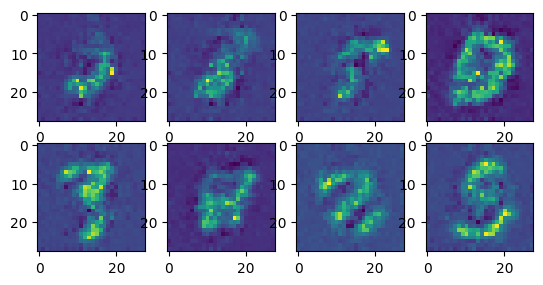

In [11]:
from matplotlib import pyplot as plt
for i in range(8):
    plt.subplot(3,4,i+1)
    plt.imshow(l[i*10])
plt.show()

In [12]:
gan.d.save('../gan_cgan/d')
gan.g.save('../gan_cgan/g')
gan.gan.save('../gan_cgan/gan')

INFO:tensorflow:Assets written to: ../gan_cgan/d\assets
INFO:tensorflow:Assets written to: ../gan_cgan/g\assets
INFO:tensorflow:Assets written to: ../gan_cgan/gan\assets
